# The energy consumption of private homes in the Netherlands in 2020

In this data analysis project we will focus on the consumption of natural gas and elektricity in private homes in 2020.
With use of the OData API, datasets on the average energy consumption per home (natural gas and electricity) of private homes will be used, subdivided into different housing types and all districts in the Netherlands from 2017 to 2020.
The OData API of the Central Bureau for Statistics (the government agency that is responsible for collecting statistical information in the Netherlands) contains datasets from Statistics Netherlands that can be imported for analysis.  The datasets can be found here: <a href="https://opendata.cbs.nl/ODataFeed/OData/85126NED">cbs.nl</a> (change the identifier to find another dataset).

<b>Main question:</b><br>
How has the average natural gas and energy consumption changed?

<b>Sub-questions:</b><ol>
    <li>How did the gas and electricity use change in the years prior to 2020?</li>
    <li>In which province is the use of natural gas and electricity the highest/lowest in 2020?</li>
    <li>Which type of home had the highest/lowest natural gas and electricity consumption in 2020?</li></ol>

In [37]:
import cbsodata
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

## 1. Load and merge datasets

All datasets are loaded first and the titles of the relevant datasets that we are going to use are displayed.

In [3]:
tables = cbsodata.get_table_list()

for table in range(530, 534):
    print(tables[table]['Title'])

Energieverbruik particuliere woningen; woningtype, wijken en buurten, 2020
Energieverbruik particuliere woningen; woningtype, wijken en buurten, 2019
Energieverbruik particuliere woningen; woningtype, wijken en buurten, 2018
Energieverbruik particuliere woningen; woningtype, wijken en buurten, 2017


Each dataset also has a unique 'identifier'. These are displayed so the data sets that we need can be loaded.

In [4]:
identifiers = []
for table in range(530, 534):
    value = tables[table]['Identifier']
    identifiers.append(value)

identifiers

['85126NED', '84837NED', '84585NED', '84314NED']

Based on the identifiers, all datasets are loaded and add an extra column with the year is added to each dataset. These four datasets will be merged into a large dataset.

In [5]:
data_2020 = pd.DataFrame(cbsodata.get_data('85126NED'))
data_2019 = pd.DataFrame(cbsodata.get_data('84837NED'))
data_2018 = pd.DataFrame(cbsodata.get_data('84585NED'))
data_2017 = pd.DataFrame(cbsodata.get_data('84314NED'))

data_2017["Jaar"] = 2017
data_2018["Jaar"] = 2018
data_2019["Jaar"] = 2019
data_2020["Jaar"] = 2020

We merge the datasets into one dataset, and ensure per dataset that the column names are not included. We also print the shape to check if all rows have been loaded.

In [14]:
all_data = pd.DataFrame(np.concatenate([data_2017.values, data_2018.values, data_2019.values, data_2020.values]), columns=data_2020.columns)
np.shape(all_data)

(543152, 11)

## 2. Cleaning data

The columns that are not needed are deleted and the remaining column names are translated.

In [15]:
all_data.drop(columns=['ID', 'Codering_3', 'Stadsverwarming_6', 'IndelingswijzigingWijkenEnBuurten_7'], inplace=True)

dict_en = {'WijkenEnBuurten': 'DistrictsAndNeighborhoods',
        'Woningkenmerken': 'PropertyFeatures',
        'Gemeentenaam_1': 'Municipality',
        'SoortRegio_2': 'RegionType',
        'GemiddeldAardgasverbruik_4': 'Gas_Use',
        'GemiddeldElektriciteitsverbruik_5': 'Electricity_Use',
        'Jaar': 'Year'}

all_data.rename(columns=dict_en,
          inplace=True)

all_data["RegionType"] = all_data["RegionType"].str.strip()
all_data["Municipality"] = all_data["Municipality"].str.strip()

all_data.head()

,DistrictsAndNeighborhoods,PropertyFeatures,Municipality,RegionType,Gas_Use,Electricity_Use,Year
0,Totaal woningen,Nederland,Nederland,Land,1240.0,2860.0,2017
1,Totaal woningen,Aa en Hunze,Aa en Hunze,Gemeente,1880.0,3220.0,2017
2,Totaal woningen,Wijk 00 Annen,Aa en Hunze,Wijk,1780.0,3270.0,2017
3,Totaal woningen,Annen,Aa en Hunze,Buurt,1760.0,3220.0,2017
4,Totaal woningen,Verspreide huizen Annen,Aa en Hunze,Buurt,2330.0,4790.0,2017


## 3. Link municipality data to province names

To see what the use of natural gas and electricity per province is, the name of the municipality needs to be linked to the name of its province. This data can easily be loaded from wikipedia websites and subsequently, with a left join the municipality names can be linked to the province names. Lastly, we check if missing values need to be removed from the dataset.

In [30]:
url = "https://en.wikipedia.org/wiki/Municipalities_of_the_Netherlands"
infotable = pd.read_html(url, match = "Province")
provinces = infotable[2]
provinces = provinces[['Municipality[a]', 'Province']]
provinces.rename(columns = {'Municipality[a]': 'Municipality'}, inplace = True)
provinces

,Municipality,Province
0,Aa en Hunze,Drenthe
1,Aalsmeer,North Holland
2,Aalten,Gelderland
3,Achtkarspelen,Friesland
4,Alblasserdam,South Holland
...,...,...
339,Zundert,North Brabant
340,Zutphen,Gelderland
341,Zwartewaterland,Overijssel
342,Zwijndrecht,South Holland


In [31]:
data_prov = pd.merge(all_data, 
                     provinces, 
                     on ='Municipality', 
                     how ='left')

data_prov[data_prov['Province'].isna()]

,DistrictsAndNeighborhoods,PropertyFeatures,Municipality,RegionType,Gas_Use,Electricity_Use,Year,Province
0,Totaal woningen,Nederland,Nederland,Land,1240.0,2860.0,2017,NaN
77,Totaal woningen,Aalburg,Aalburg,Gemeente,1640.0,3620.0,2017,NaN
78,Totaal woningen,Wijk 00 Wijk en Aalburg,Aalburg,Wijk,1590.0,3620.0,2017,NaN
79,Totaal woningen,Wijk en Aalburg,Aalburg,Buurt,1500.0,3480.0,2017,NaN
80,Totaal woningen,Spijk,Aalburg,Buurt,2160.0,4510.0,2017,NaN
...,...,...,...,...,...,...,...,...
531163,Weespersluis,Hoekwoning,Weesp,Buurt,1230.0,2740.0,2020,NaN
531164,Weespersluis,Twee-onder-één-kap woning,Weesp,Buurt,1440.0,3410.0,2020,NaN
531165,Weespersluis,Vrijstaande woning,Weesp,Buurt,1710.0,3700.0,2020,NaN
531166,Weespersluis,Eigen woning,Weesp,Buurt,1200.0,2900.0,2020,NaN


Less than 7% of the values (35,776 rows) have NaN values, because the municipality name is not in the list of provinces. These will be removed, unless the column Municipality states 'Netherlands'.

In [33]:
data_prov = data_prov[(data_prov.Province == 'Nederland') | (data_prov.Province.notna())]
data_prov.head()

,DistrictsAndNeighborhoods,PropertyFeatures,Municipality,RegionType,Gas_Use,Electricity_Use,Year,Province
1,Totaal woningen,Aa en Hunze,Aa en Hunze,Gemeente,1880.0,3220.0,2017,Drenthe
2,Totaal woningen,Wijk 00 Annen,Aa en Hunze,Wijk,1780.0,3270.0,2017,Drenthe
3,Totaal woningen,Annen,Aa en Hunze,Buurt,1760.0,3220.0,2017,Drenthe
4,Totaal woningen,Verspreide huizen Annen,Aa en Hunze,Buurt,2330.0,4790.0,2017,Drenthe
5,Totaal woningen,Wijk 01 Eext,Aa en Hunze,Wijk,1940.0,3220.0,2017,Drenthe


Finally, the columns will be reordered and the column 'Year' is change to the time type. Now we have a clean dataset that we can  use for our analysis.

In [34]:
data_prov = data_prov[['Year', 'PropertyFeatures', 'RegionType','Municipality','Province','Gas_Use', 'Electricity_Use']]
data_prov['Year'] = pd.to_datetime(data_prov['Year'], format='%Y').dt.year

data_prov

,Year,PropertyFeatures,RegionType,Municipality,Province,Gas_Use,Electricity_Use
1,2017,Aa en Hunze,Gemeente,Aa en Hunze,Drenthe,1880.0,3220.0
2,2017,Wijk 00 Annen,Wijk,Aa en Hunze,Drenthe,1780.0,3270.0
3,2017,Annen,Buurt,Aa en Hunze,Drenthe,1760.0,3220.0
4,2017,Verspreide huizen Annen,Buurt,Aa en Hunze,Drenthe,2330.0,4790.0
5,2017,Wijk 01 Eext,Wijk,Aa en Hunze,Drenthe,1940.0,3220.0
...,...,...,...,...,...,...,...
543147,2020,Hoekwoning,Buurt,Zwolle,Overijssel,NaN,NaN
543148,2020,Twee-onder-één-kap woning,Buurt,Zwolle,Overijssel,1820.0,3910.0
543149,2020,Vrijstaande woning,Buurt,Zwolle,Overijssel,2010.0,4240.0
543150,2020,Eigen woning,Buurt,Zwolle,Overijssel,1900.0,4370.0


## Question 1: How did the gas and electricity use change in the years prior to 2020?

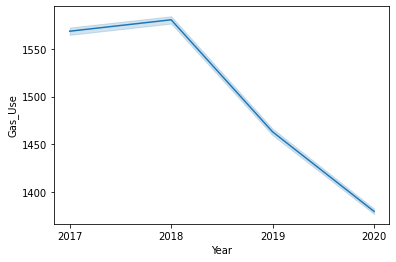

In [39]:
a = sns.lineplot(x='Year', y='Gas_Use', data=data_prov);
a.set_xticks(range(2017,2021));

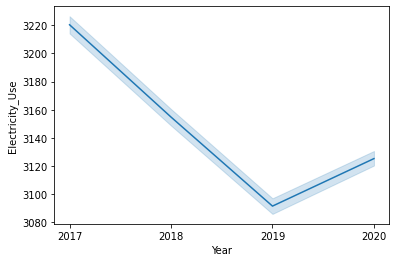

In [36]:
b = sns.lineplot(x='Year', y='Electricity_Use', data=data_prov)
b.set_xticks(range(2017,2021));

<b>Answer:</b><br>
We see that in 2018 there was a slight peak in the use of natural gas, after which the use has fallen sharply to below 1400m³ up to 2020. This fits with the trend of the declining consumption of natural gas. Electricity use declined sharply from 2017 to 2019, after which there was a slight increase again. This could be due to more working from home because of corona and that people therefore used more electricity at home.

## Question 2: In which province was the use of natural gas and electricity the highest/lowest in 2020?

To see which province had the lowest and highest natural gas en electricity consumption in 2020, the data will be grouped per province. Furthermore, a GIS dataset that contains the geographical boundaries per province will be used. This dataset also comes from the CBS and can be found <a href="https://pythoncursus.nl/wp-content/uploads/2020/11/data.zip">here</a>. The data will be plotted with a map to see which provinces use the most and the least natural gas and electricity.

In [141]:
# Data is grouped by province and the values are sorted
data_prov_2020 = data_prov[data_prov['Year'] == 2020]
gas_2020 = data_prov_2020.groupby(['Province'])[['Gas_Use']].sum()
elek_2020 = data_prov_2020.groupby(['Province'])[['Electricity_Use']].sum()

gas_2020 = gas_2020.sort_values(by='Gas_Use')
elek_2020 = elek_2020.sort_values(by='Electricity_Use')

In [73]:
# The province border data is loaded and some names translated to English
gdf_prov = gpd.read_file('B1_Provinciegrenzen_van_NederlandPolygon.shp')
gdf_prov.rename(columns = {'PROV_NAAM': 'Province'}, inplace = True)
gdf_prov.loc[gdf_prov["Province"] == "Noord-Holland", "Province"] = "North Holland"
gdf_prov.loc[gdf_prov["Province"] == "Noord-Brabant", "Province"] = "North Brabant"
gdf_prov.loc[gdf_prov["Province"] == "Zuid-Holland", "Province"] = "South Holland"

gdf_prov

,CBS_CODE,Province,OBJECTID,geometry
0,2.0,Friesland,1.0,"POLYGON ((166000.000 609500.000, 170000.000 61..."
1,7.0,North Holland,2.0,"POLYGON ((101235.450 510060.270, 101416.000 51..."
2,5.0,Gelderland,3.0,"POLYGON ((170028.343 445109.103, 169993.088 44..."
3,3.0,Drenthe,4.0,"POLYGON ((223906.541 555883.385, 223861.932 55..."
4,6.0,Utrecht,5.0,"POLYGON ((121128.562 463852.646, 121106.940 46..."
5,11.0,Limburg,6.0,"POLYGON ((183893.796 341247.943, 183920.500 34..."
6,12.0,Flevoland,7.0,"POLYGON ((153237.540 520920.310, 153251.528 52..."
7,9.0,Zeeland,8.0,"POLYGON ((23205.420 400019.760, 29183.080 4033..."
8,10.0,North Brabant,9.0,"MULTIPOLYGON (((142358.861 416946.400, 142363...."
9,8.0,South Holland,10.0,"POLYGON ((72558.000 453255.000, 72993.800 4537..."


In [86]:
# The geometrical data is linked to the natural gas and electricity use per province.
gasprov_2020 = pd.merge(gas_2020, 
                     gdf_prov, 
                     on ='Province', 
                     how ='left')
gasprov_2020['area'] = gdf_prov.area

elecprov_2020 = pd.merge(elek_2020, 
                     gdf_prov, 
                     on ='Province', 
                     how ='left')
elecprov_2020['area'] = gdf_prov.area

gasprov_2020 = gpd.GeoDataFrame(gasprov_2020, crs="EPSG:28992", geometry=gdf_prov['geometry'])
elecprov_2020 = gpd.GeoDataFrame(elecprov_2020, crs="EPSG:28992", geometry=gdf_prov['geometry'])

gasprov_2020

,Province,Gas_Use,CBS_CODE,OBJECTID,geometry,area
0,Flevoland,2029180.0,12.0,7.0,"POLYGON ((166000.000 609500.000, 170000.000 61...",5.748762e+09
1,Zeeland,5030470.0,9.0,8.0,"POLYGON ((101235.450 510060.270, 101416.000 51...",4.091927e+09
2,Groningen,5821200.0,1.0,12.0,"POLYGON ((170028.343 445109.103, 169993.088 44...",5.136305e+09
3,Drenthe,7537940.0,3.0,4.0,"POLYGON ((223906.541 555883.385, 223861.932 55...",2.680393e+09
4,Utrecht,9763620.0,6.0,5.0,"POLYGON ((121128.562 463852.646, 121106.940 46...",1.560054e+09
5,Friesland,9901740.0,2.0,1.0,"POLYGON ((183893.796 341247.943, 183920.500 34...",2.209850e+09
6,Limburg,11308750.0,11.0,6.0,"POLYGON ((153237.540 520920.310, 153251.528 52...",2.412307e+09
7,Overijssel,12659800.0,4.0,11.0,"POLYGON ((23205.420 400019.760, 29183.080 4033...",2.933437e+09
8,North Holland,18009020.0,7.0,2.0,"MULTIPOLYGON (((142358.861 416946.400, 142363....",5.082056e+09
9,Gelderland,19900730.0,5.0,3.0,"POLYGON ((72558.000 453255.000, 72993.800 4537...",3.307860e+09


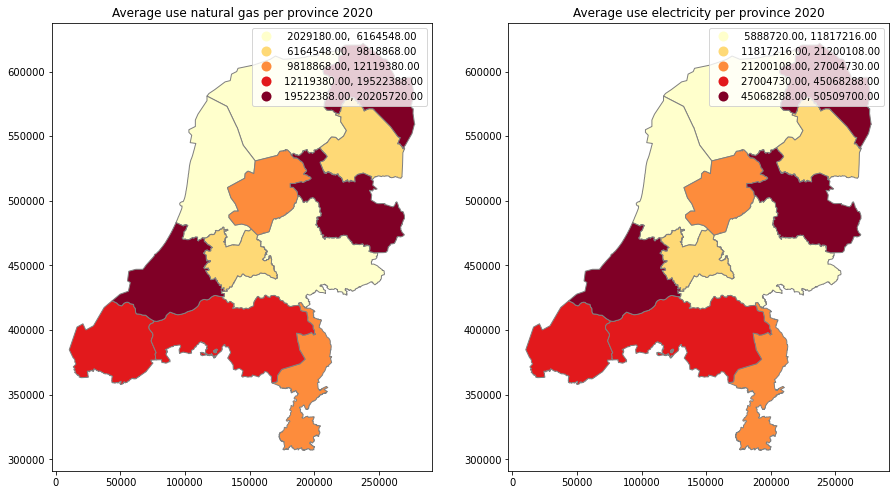

In [107]:
fig, ax = plt.subplots(ncols=2, figsize=(15,15))

gasprov_2020.plot(column='Gas_Use', scheme='Quantiles', k=5, edgecolor='gray', cmap='YlOrRd', legend=True, ax=ax[0])
ax[0].set_title('Average use natural gas per province 2020')
elecprov_2020.plot(column='Electricity_Use', scheme='Quantiles', k=5, edgecolor='gray', cmap='YlOrRd', legend=True, ax=ax[1])
ax[1].set_title('Average use electricity per province 2020');

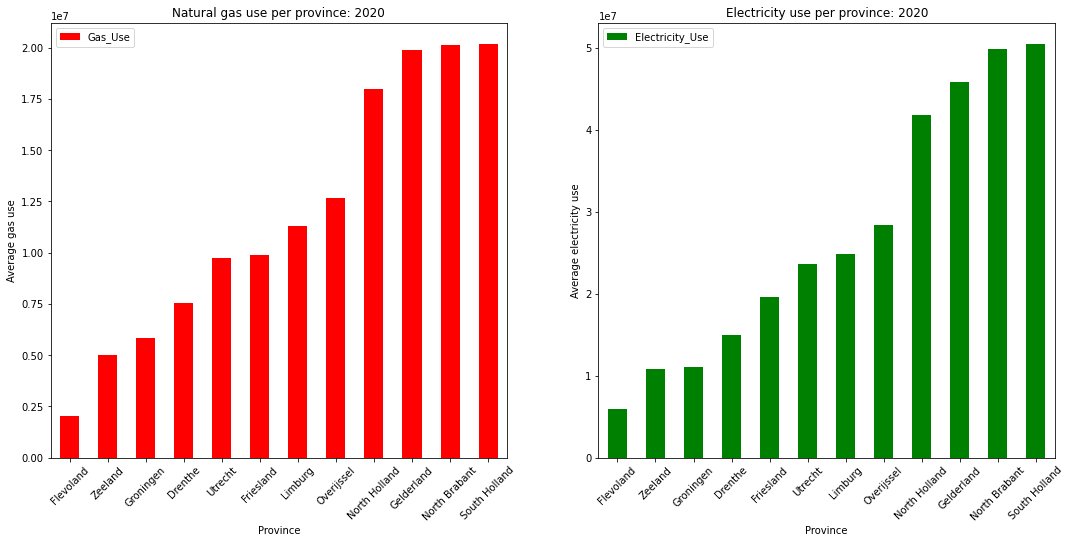

In [140]:
fig, ax = plt.subplots(ncols=2)

gas_2020.plot(kind='bar', title='Natural gas use per province: 2020', 
               ylabel='Average gas use', color='r', figsize=(18, 8), ax=ax[0])
ax[0].tick_params(axis='x', labelrotation = 45)
elek_2020.plot(kind='bar', title='Electricity use per province: 2020', 
               ylabel='Average electricity use', color='g', figsize=(18, 8), ax=ax[1])
ax[1].tick_params(axis='x', labelrotation = 45);

<b>Answer:</b><br>
From the maps and the aforementioned bar plots can be concluded that both the average natural gas consumption and the electricity consumption in 2020 were highest in: <u>Gelderland, North Brabant and South Holland</u>. The use was the lowest in: <u>Flevoland, Zeeland and Groningen</u>.

## Question 3: Which type of home had the highest/lowest natural gas and electricity consumption in 2020?

Finally, we examine for which type of home the natural gas and electricity consumption was the highest and lowest in 2020.

In [160]:
homes_nl = ['Appartement', 'Huurwoning', 'Tussenwoning', 'Hoekwoning',
            'Twee-onder-één-kap woning', 'Eigen woning', 'Vrijstaande woning']
homes = ['Apartment', 'Rental house', 'Intermediate house', 'Corner house',
             'Semi-detached house', 'Own house', 'Detached house']

df_homes = data_prov.loc[data_prov["PropertyFeatures"].isin(homes_nl)]
df_homes = df_homes[df_homes["Year"] == 2020]

df_homes.loc[df_homes["PropertyFeatures"] == "Appartement", "PropertyFeatures"] = "Apartment"
df_homes.loc[df_homes["PropertyFeatures"] == "Tussenwoning", "PropertyFeatures"] = "Intermediate house"
df_homes.loc[df_homes["PropertyFeatures"] == "Huurwoning", "PropertyFeatures"] = "Rental house"
df_homes.loc[df_homes["PropertyFeatures"] == "Hoekwoning", "PropertyFeatures"] = "Corner house"
df_homes.loc[df_homes["PropertyFeatures"] == "Twee-onder-één-kap woning", "PropertyFeatures"] = "Semi-detached house"
df_homes.loc[df_homes["PropertyFeatures"] == "Eigen woning", "PropertyFeatures"] = "Own house"
df_homes.loc[df_homes["PropertyFeatures"] == "Vrijstaande woning", "PropertyFeatures"] = "Detached house"

df_homes

,Year,PropertyFeatures,RegionType,Municipality,Province,Gas_Use,Electricity_Use
404433,2020,Apartment,Gemeente,Aa en Hunze,Drenthe,900.0,1870.0
404434,2020,Intermediate house,Gemeente,Aa en Hunze,Drenthe,1190.0,2250.0
404435,2020,Corner house,Gemeente,Aa en Hunze,Drenthe,1360.0,2520.0
404436,2020,Semi-detached house,Gemeente,Aa en Hunze,Drenthe,1450.0,2870.0
404437,2020,Detached house,Gemeente,Aa en Hunze,Drenthe,2010.0,3660.0
...,...,...,...,...,...,...,...
543147,2020,Corner house,Buurt,Zwolle,Overijssel,NaN,NaN
543148,2020,Semi-detached house,Buurt,Zwolle,Overijssel,1820.0,3910.0
543149,2020,Detached house,Buurt,Zwolle,Overijssel,2010.0,4240.0
543150,2020,Own house,Buurt,Zwolle,Overijssel,1900.0,4370.0


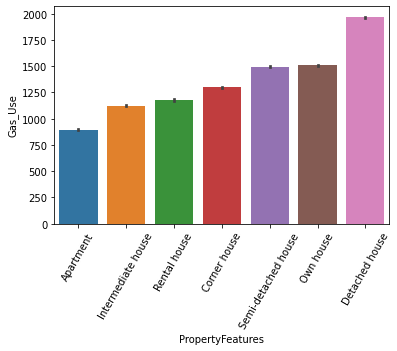

In [157]:
b = sns.barplot(x="PropertyFeatures", y="Gas_Use", data=df_homes, order=homes)
b.set_xticklabels(b.get_xticklabels(), rotation=60);

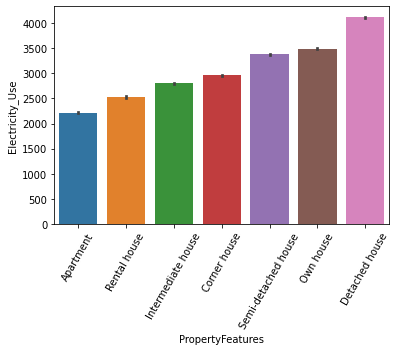

In [162]:
c = sns.barplot(x="PropertyFeatures", y="Electricity_Use", data=df_homes, order=homes)
c.set_xticklabels(c.get_xticklabels(), rotation=60);

<b>Answer:</b><br>
The graphs above show that average natural gas and electricity consumption is lowest in apartments, rental and intermediate houses, and the highest in owned homes and detached houses. This makes sense since houses tend to be larger than apartments and therfore, it takes more energy to heat a bigger space than a smaller space.